<a href="https://colab.research.google.com/github/MengxuanMa2016/Data_Visualization_Python/blob/master/Visualization_of_assessment_outcomes_smoothness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Efficiency Assessment Result Visualization**

The purpose of this notebook is to visaulize the processed assessment results of a stroke player. 

Main steps: 
a. Load the generetated assessment file in csv. 

## Load the necessary libraries

In [0]:
from numpy import genfromtxt
import numpy as np, pandas as pd
from IPython.display import display, HTML
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import seaborn as sns
import csv

import scipy.stats as stats
import statsmodels as sm

import warnings
warnings.filterwarnings('ignore')

## Link the notebook to the google drive to import the file

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# list data files are available in the data directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

path = "/content/gdrive/My Drive/Assessment_Data_Visualization/"

from subprocess import check_output
print(check_output(["ls", path]).decode("utf8"))

# Any results you write to the current directory are saved as output.

HS1-ALL-efficiency_metrics012019.csv
HS1-ALL-extent_metrics012019.csv
HS1-ALL-speedsmoothness_metrics012019.csv
HS1-ALL-trial_list012019.csv
HS2-ALL-efficiency_metrics011819.csv
HS2-ALL-extent_metrics011819.csv
HS2-ALL-speedsmoothness_metrics011819.csv
HS2-ALL-trial_list011819.csv
HS4-ALL-efficiency_metrics011719.csv
HS4-ALL-extent_metrics011719.csv
HS4-ALL-speedsmoothness_metrics011719.csv
HS4-ALL-trial_list011719.csv
HS5-ALL-efficiency_metrics011619.csv
HS5-ALL-extent_metrics011619.csv
HS5-ALL-speedsmoothness_metrics011619.csv
HS5-ALL-trial_list011619.csv
HS7-ALL-efficiency_metrics011819.csv
HS7-ALL-extent_metrics011819.csv
HS7-ALL-speedsmoothness_metrics011819.csv
HS7-ALL-trial_list011819.csv
HS8-ALL-efficiency_metrics011819.csv
HS8-ALL-extent_metrics011819.csv
HS8-ALL-speedsmoothness_metrics011819.csv
HS8-ALL-trial_list011819.csv
KL30-ALL-efficiency_metrics012019.csv
KL30-ALL-extent_metrics012019.csv
KL30-ALL-speedsmoothness_metrics012019.csv
KL30-ALL-trial_list012019.csv
LSVT1-ALL

## Select client

In [9]:
# Choose a client for analysis
# Client list: HS1, HS2, HS4, HS5, HS7, HS8, LSVT1, LSVT2
Client = input('Select a client from the following list:\nHS1, HS2, HS4, HS5, HS7, HS8, LSVT1, LSVT2\n')

Select a client from the following list:
HS1, HS2, HS4, HS5, HS7, HS8, LSVT1, LSVT2
HS7


## Find the files of the corresponding client under the directory

In [10]:
healthy_data_file = 'KL30-ALL-speedsmoothness_metrics012019.csv'

if Client == "HS1":
  stroke_data_file = 'HS1-ALL-speedsmoothness_metrics012019.csv'
  stroke_trial_file = 'HS1-ALL-trial_list012019.csv'
  
elif Client == "HS2":
  stroke_data_file = 'HS2-ALL-speedsmoothness_metrics011819.csv'
  stroke_trial_file = 'HS2-ALL-trial_list011819.csv'
  
elif Client == "HS4":
  stroke_data_file = 'HS4-ALL-speedsmoothness_metrics011719.csv'
  stroke_trial_file = 'HS4-ALL-trial_list011719.csv'
  
elif Client == "HS5":
  stroke_data_file = 'HS5-ALL-speedsmoothness_metrics011619.csv'
  stroke_trial_file = 'HS5-ALL-trial_list011619.csv'  

elif Client == "HS7":
  stroke_data_file = 'HS7-ALL-speedsmoothness_metrics011819.csv'
  stroke_trial_file = 'HS7-ALL-trial_list011819.csv'
  
elif Client == "HS8":
  stroke_data_file = 'HS8-ALL-speedsmoothness_metrics011819.csv'
  stroke_trial_file = 'HS8-ALL-trial_list011819.csv'  
  
elif Client == "LSVT1":
  stroke_data_file = 'LSVT1-ALL-speedsmoothness_metrics012019.csv'
  stroke_trial_file = 'LSVT1-ALL-trial_list012019.csv'  
  
elif Client == "LSVT2":
  stroke_data_file = 'LSVT2-ALL-speedsmoothness_metrics012019.csv'
  stroke_trial_file = 'LSVT2-ALL-trial_list012019.csv'
  
else:
  print("No records for selected client!")
  
print("Files to be processed:")
print(stroke_data_file)
print(stroke_trial_file)
  

Files to be processed:
HS7-ALL-speedsmoothness_metrics011819.csv
HS7-ALL-trial_list011819.csv


## Some functions

In [0]:
def read_trial_info(trial):
    label = []
    with open(trial, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            label.append(row[0])
    partial_label = [x.split("_") for x in label]
      
    return partial_label

In [0]:
def read_joint_file(trial):
    """
    read_joint_file method: read the joint file(.csv) to an array
    :param
        trial: directory of the file to be read
    :return:
        an array of data read from the file.
    """
    print("Reading trial -- " + trial)

    # read the actual data from .csv file
    file_data = genfromtxt(trial, delimiter=',')
    # print(type(file_data))

    data_raw = file_data[:]

    print("Finish Reading!")

    return data_raw

In [0]:
def indexing_by_datatime(dataframe):
  """
  Sort the rows of the input dataframe by the data and time. 
  Add an index column for sorted sequence.
  input: A dataframe with _Date and _Time columns included.
  return: The dataframe with rows sorted.
  """
  
  sorted_dataframe = dataframe.sort_values(['_Date','_Time'],ascending=[True, True])
  sorted_dataframe['index'] = range(1, len(dataframe) + 1)
  
  return sorted_dataframe

In [0]:
def overtime_analysis(stroke_dataframe, metric_left, metric_right, title, baseline_dataframe=[]):
  
  plot_baseline = False
  # compute the baseline if the health dataframe is available.
  if len(baseline_dataframe) != 0 :
    plot_baseline = True
    left_baseline, right_baseline = compute_baseline(baseline_dataframe, metric_left, metric_right)
  else:
    print("Baseline is not available!")
    
  stroke_dataframe[metric_left]  = stroke_dataframe[metric_left].convert_objects(convert_numeric=True)
  stroke_dataframe[metric_right] = stroke_dataframe[metric_right].convert_objects(convert_numeric=True)
    
  # sort the rows of the analysis dataframe by data and time
  analysis_df = indexing_by_datatime(stroke_dataframe)
  
  fig = plt.figure()
  fig.set_size_inches(12.5, 8.5)
  ax = fig.add_subplot(111)
  sns.regplot(x='index', y=metric_left , data=analysis_df, order=2)
  sns.regplot(x='index', y=metric_right, data=analysis_df, order=2)

  if plot_baseline == True:
    plt.axhline(y= left_baseline , color = 'purple', linestyle='--')
    plt.axhline(y= right_baseline, color = 'blue'  , linestyle='--')

  plt.xticks(analysis_df['index'],analysis_df["_Date"],rotation = 90)
  
  plt.title(title)
  plt.xlabel("trials")
  plt.ylabel(metric_left[:len(metric_left)-5])

  ax.grid(False)

  plt.show()
  
  return analysis_df
  
  

## Import the base line: Healthy subjects assessment results

In [15]:
healthy_data = read_joint_file(path + healthy_data_file)
# print (type(healthy_data))

Reading trial -- /content/gdrive/My Drive/Assessment_Data_Visualization/KL30-ALL-speedsmoothness_metrics012019.csv
Finish Reading!


In [16]:
headers = ['Max_Speed_Left', 'Max_Speed_Right',	'Mean_Speed_Left',	'Mean_Speed_Right','Mean/Max_Left',	'Mean/Max_Right',	\
           'Norm_Jerk_x_Left',	'Norm_Jerk_y_Left',	'Norm_Jerk_z_Left',	'Norm_Jerk_x_Right',	'Norm_Jerk_y_Right',	'Norm_Jerk_z_Right',\
           'Norm_Jerk_3d_Left',	'Norm_Jerk_3d_Right']

health_trial_data_dict = dict(zip(headers, healthy_data.T))

health_df = pd.DataFrame(health_trial_data_dict)

print("Display the first five rows of the healthy subject table")
display(health_df[:5])

Display the first five rows of the healthy subject table


,Max_Speed_Left,Max_Speed_Right,Mean/Max_Left,Mean/Max_Right,Mean_Speed_Left,Mean_Speed_Right,Norm_Jerk_3d_Left,Norm_Jerk_3d_Right,Norm_Jerk_x_Left,Norm_Jerk_x_Right,Norm_Jerk_y_Left,Norm_Jerk_y_Right,Norm_Jerk_z_Left,Norm_Jerk_z_Right
0,6047.834305,3605.976500,0.106630,0.169721,644.879837,612.008283,3.416991e+07,5.376917e+07,1.740587e+07,3.180303e+07,2.432067e+07,3.782446e+07,1.652645e+07,2.118965e+07
1,2831.433207,2709.645147,0.128380,0.125699,363.499315,340.598922,1.181549e+07,2.027060e+07,5.236703e+06,9.960844e+06,5.339031e+06,6.109913e+06,9.147542e+06,1.656344e+07
2,3068.287801,2847.551826,0.110768,0.103406,339.867783,294.454674,4.080738e+07,4.194645e+07,2.004988e+07,1.571520e+07,1.478440e+07,1.588973e+07,3.232129e+07,3.549724e+07
3,2639.154970,2397.243587,0.132898,0.149023,350.738819,357.243977,1.010887e+07,1.438159e+07,6.459253e+06,1.120126e+07,4.827538e+06,4.390710e+06,6.096088e+06,7.879309e+06
4,5018.843340,2976.660520,0.056492,0.090186,283.524935,268.454549,8.791738e+07,5.931263e+07,5.740888e+07,3.815575e+07,3.375427e+07,2.247426e+07,5.739630e+07,3.945928e+07


## Import the stroke data

In [17]:
stroke_data = read_joint_file(path + stroke_data_file)

print("stroke data:\n" + str(stroke_data[:3,:]))
print(stroke_data.shape)


trail_info = read_trial_info(path + stroke_trial_file)
trail_info = np.asarray(trail_info)
print("trail_info: \n" + str(trail_info[:5,:]))

Reading trial -- /content/gdrive/My Drive/Assessment_Data_Visualization/HS7-ALL-speedsmoothness_metrics011819.csv
Finish Reading!
stroke data:
[[3.11508992e+03 2.54752702e+03 2.11708481e+02 2.32856772e+02
  6.79620000e-02 9.14050000e-02 1.07850920e+08 1.12840999e+08
  1.44721535e+08 5.19354829e+08 7.97433268e+08 9.22116519e+08
  2.12859660e+08 1.32511438e+09]
 [3.70251141e+03 3.41408052e+03 5.87872977e+02 5.95326341e+02
  1.58777000e-01 1.74374000e-01 1.33278994e+09 9.83363080e+08
  8.26513205e+08 2.13488180e+10 1.51624646e+10 1.22984594e+10
  1.85106889e+09 2.89296468e+10]
 [2.12772180e+02 1.54920903e+03 4.38269470e+01 2.24229363e+02
  2.05981000e-01 1.44738000e-01 1.64868726e+05 2.79986481e+05
  4.66524929e+04 1.27380802e+05 1.97072801e+05 1.34538410e+05
  3.28253837e+05 2.70488708e+05]]
(92, 14)
trail_info: 
[['4-12-2018' '07-49-PM' 'KL2HS' '007' 'standing']
 ['4-12-2018' '07-52-PM' 'KL2HS' '007' 'standing']
 ['4-12-2018' '07-56-PM' 'KL2HS' '007' 'standing']
 ['4-12-2018' '07-58-PM'

## Build up a pandas table of the stroke assessment data

In [18]:
headers = ['_Date','_Time','_Player','_PlayerId','_Type', \
           'Max_Speed_Left', 'Max_Speed_Right',	'Mean_Speed_Left',	'Mean_Speed_Right','Mean/Max_Left',	'Mean/Max_Right',	\
           'Norm_Jerk_x_Left',	'Norm_Jerk_y_Left',	'Norm_Jerk_z_Left',	'Norm_Jerk_x_Right',	'Norm_Jerk_y_Right',	'Norm_Jerk_z_Right',\
           'Norm_Jerk_3d_Left',	'Norm_Jerk_3d_Right']

stroke_trial_data = np.concatenate((trail_info, stroke_data), axis=1)
# print("trial with data: \n" + str(stroke_trial_data[:3,0:3]))

stroke_trial_data_dict = dict(zip(headers, stroke_trial_data.T))

stroke_df = pd.DataFrame(stroke_trial_data_dict)
# # print(stroke_df.head())

display(stroke_df[:5])

,Max_Speed_Left,Max_Speed_Right,Mean/Max_Left,Mean/Max_Right,Mean_Speed_Left,Mean_Speed_Right,Norm_Jerk_3d_Left,Norm_Jerk_3d_Right,Norm_Jerk_x_Left,Norm_Jerk_x_Right,Norm_Jerk_y_Left,Norm_Jerk_y_Right,Norm_Jerk_z_Left,Norm_Jerk_z_Right,_Date,_Player,_PlayerId,_Time,_Type
0,3115.089924,2547.527025,0.067962,0.091405,211.708481,232.856772,212859659.730045,1325114383.493175,107850920.398265,519354828.782655,112840998.994683,797433268.035499,144721534.87135,922116518.771277,4-12-2018,KL2HS,007,07-49-PM,standing
1,3702.511407,3414.080517,0.158777,0.174374,587.872977,595.326341,1851068892.871973,28929646774.03458,1332789938.878711,21348817957.189922,983363080.233706,15162464567.908138,826513204.622423,12298459355.87479,4-12-2018,KL2HS,007,07-52-PM,standing
2,212.77218,1549.209025,0.205981,0.144738,43.826947,224.229363,328253.836915,270488.707872,164868.726262,127380.801814,279986.480848,197072.800547,46652.492889,134538.409757,4-12-2018,KL2HS,007,07-56-PM,standing
3,2645.579855,3098.28139,0.059386,0.065533,157.109202,203.041003,321050889.966997,243636843.32653,170472553.509594,106391767.017085,71073160.882391,48784190.161158,262605004.237743,213681553.081726,4-12-2018,KL2HS,007,07-58-PM,SitWeights
4,2575.115383,3926.652111,0.087389,0.057646,225.036487,226.354057,57227530.619656,176646491.586158,21626431.055611,65790211.770291,26961089.414272,52579932.977213,45611263.94013,155277112.521552,4-12-2018,KL2HS,007,08-01-PM,SitWeights


In [0]:
# stroke_df['_Date'] = pd.to_datetime(stroke_df['_Date'])
# display(stroke_df[:5])

## Format the date column by padding zeros

In [19]:
def date_format(str):
  str_split = str.split("-")
  str_format = str_split[0].zfill(2) + '-' + str_split[1].zfill(2) + '-' + str_split[2].zfill(4)
  
  return str_format

stroke_df['_Date'] = np.asarray(list(map(date_format, stroke_df['_Date'])))

display(stroke_df[:5])

,Max_Speed_Left,Max_Speed_Right,Mean/Max_Left,Mean/Max_Right,Mean_Speed_Left,Mean_Speed_Right,Norm_Jerk_3d_Left,Norm_Jerk_3d_Right,Norm_Jerk_x_Left,Norm_Jerk_x_Right,Norm_Jerk_y_Left,Norm_Jerk_y_Right,Norm_Jerk_z_Left,Norm_Jerk_z_Right,_Date,_Player,_PlayerId,_Time,_Type
0,3115.089924,2547.527025,0.067962,0.091405,211.708481,232.856772,212859659.730045,1325114383.493175,107850920.398265,519354828.782655,112840998.994683,797433268.035499,144721534.87135,922116518.771277,04-12-2018,KL2HS,007,07-49-PM,standing
1,3702.511407,3414.080517,0.158777,0.174374,587.872977,595.326341,1851068892.871973,28929646774.03458,1332789938.878711,21348817957.189922,983363080.233706,15162464567.908138,826513204.622423,12298459355.87479,04-12-2018,KL2HS,007,07-52-PM,standing
2,212.77218,1549.209025,0.205981,0.144738,43.826947,224.229363,328253.836915,270488.707872,164868.726262,127380.801814,279986.480848,197072.800547,46652.492889,134538.409757,04-12-2018,KL2HS,007,07-56-PM,standing
3,2645.579855,3098.28139,0.059386,0.065533,157.109202,203.041003,321050889.966997,243636843.32653,170472553.509594,106391767.017085,71073160.882391,48784190.161158,262605004.237743,213681553.081726,04-12-2018,KL2HS,007,07-58-PM,SitWeights
4,2575.115383,3926.652111,0.087389,0.057646,225.036487,226.354057,57227530.619656,176646491.586158,21626431.055611,65790211.770291,26961089.414272,52579932.977213,45611263.94013,155277112.521552,04-12-2018,KL2HS,007,08-01-PM,SitWeights


## Determine the metric for analysis

In [24]:
# metrics for assessing the movement smoothness 
# 'Mean/Max_Left',	'Mean/Max_Right', 'Norm_Jerk_3d_Left',	'Norm_Jerk_3d_Right'

metric_option = input('Select a metric from the following options:\n1--Mean/Max speed ratio\n2--Normalized jerk\n')
metric_left = ''
metric_right = ''
metric = ''
  
if metric_option == '1':
  metric_left = 'Mean/Max_Left'
  metric_right = 'Mean/Max_Right'
  metric = 'Mean/Max speed ratio'
elif metric_option == '2':
  metric_left = 'Norm_Jerk_3d_Left'
  metric_right = 'Norm_Jerk_3d_Right'
  metric = 'Normalized jerk'  
else:
  print("Selected invalid metric. Run this cell again to reselect it.")

print('Metric selected: ' + metric)

  

Select a metric from the following options:
1--Mean/Max speed ratio
2--Normalized jerk
2
Metric selected: Normalized jerk


## Determine the base line from the assessment results of healthy subjects

In [0]:
def compute_baseline(health_dataframe, metric_left, metric_right):
  """
  input parameters: 
  health_dataframe: the dataframe with left and right hand metric columns including.
  metric_left/right : the column name to compute the baseline. 
  
  return parameters:
  left/right_baseline: The average of the selected metric column.
  
  usage:
  left_baseline, right_baseline = compute_baseline(health_df, metric_left, metric_right)
  print("left baseline = {:f}, right baseline = {:f}.".format(left_baseline, right_baseline))
  """
  
  left_baseline = health_df[metric_left].mean()
  right_baseline = health_df[metric_right].mean()
  print("left baseline = {:f}, right baseline = {:f}.".format(left_baseline, right_baseline))
  
  return left_baseline, right_baseline

In [26]:
left_baseline, right_baseline = compute_baseline(health_df, metric_left, metric_right)
# print("left baseline = {:f}, right baseline = {:f}.".format(left_baseline, right_baseline))

left baseline = 116099562.982066, right baseline = 105513241.429094.


## Trend for all the trials

left baseline = 116099562.982066, right baseline = 105513241.429094.


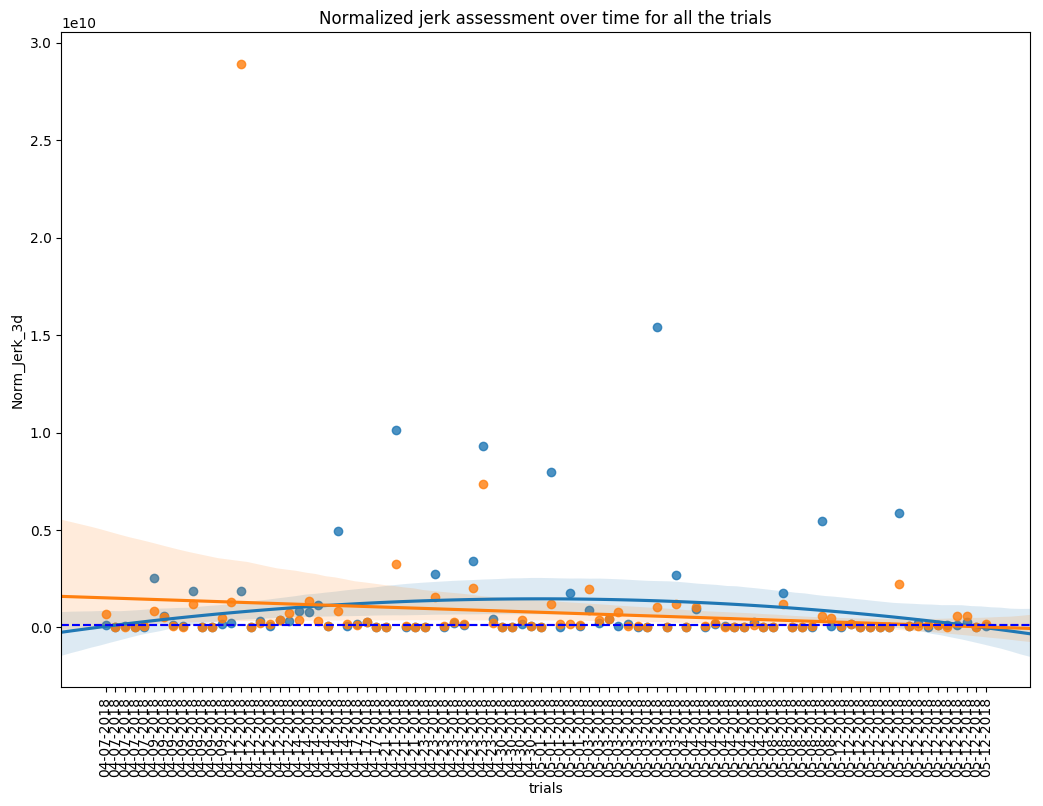

In [27]:
title = metric + ' assessment over time for all the trials'
display_df = overtime_analysis(stroke_df, metric_left, metric_right, title, baseline_dataframe=health_df)

# display_df = overtime_analysis(stroke_df, metric_left, metric_right)

# display(display_df)

## Trend for a day

In [28]:
# list all the game types
print(stroke_df._Date.unique())

['04-12-2018' '04-14-2018' '04-17-2018' '04-21-2018' '04-23-2018'
 '04-30-2018' '04-07-2018' '04-09-2018' '05-01-2018' '05-12-2018'
 '05-03-2018' '05-04-2018' '05-08-2018']


In [30]:
selected_date = '04-07-2018'
one_day_df = stroke_df.loc[stroke_df['_Date'] == selected_date]
one_day_df = one_day_df[[metric_left, metric_right,'_Date','_Type','_Time']]
display(one_day_df)

,Norm_Jerk_3d_Left,Norm_Jerk_3d_Right,_Date,_Type,_Time
32,1.255729e+08,6.965008e+08,04-07-2018,standing,10-14-AM
33,6.938704e+03,6.189732e+03,04-07-2018,stand step,10-17-AM
34,1.015747e+08,3.606370e+07,04-07-2018,stand step,10-20-AM
35,3.954702e+06,2.991859e+06,04-07-2018,SitWeights,10-33-AM
36,1.182091e+07,8.852877e+07,04-07-2018,stand weights,10-40-AM


left baseline = 116099562.982066, right baseline = 105513241.429094.


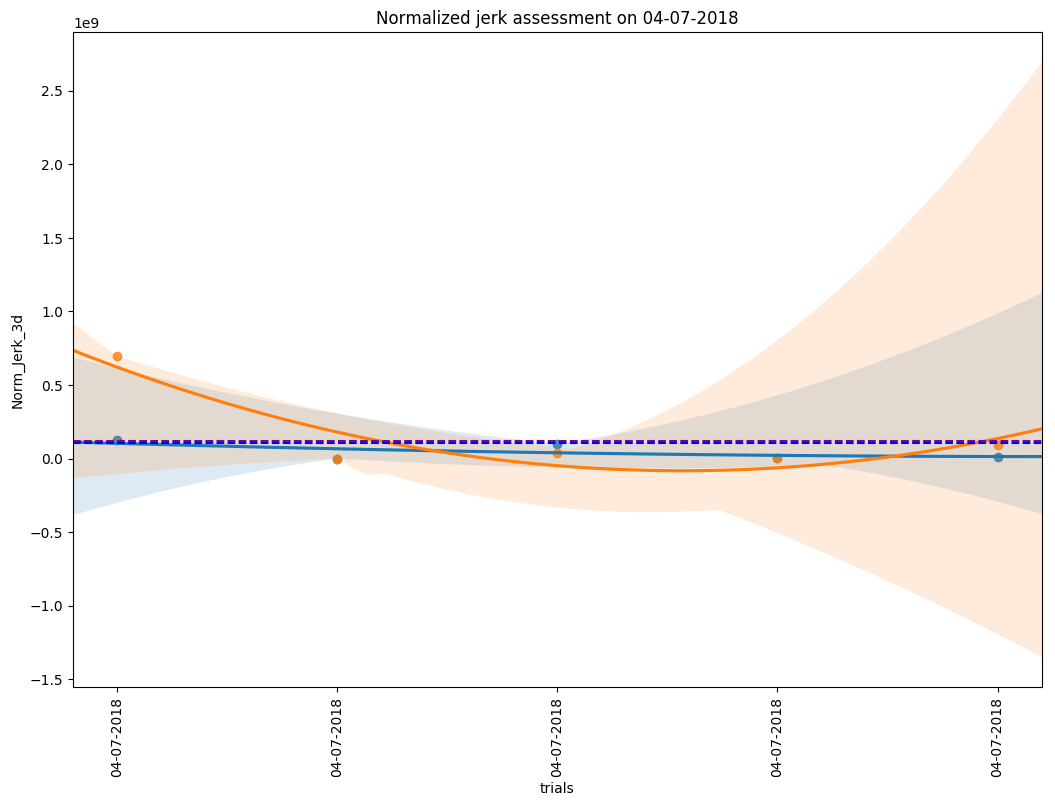

In [31]:
one_day_title = metric + ' assessment on ' + selected_date
one_day_display_df = overtime_analysis(one_day_df, metric_left,metric_right, one_day_title, baseline_dataframe=health_df)

## Trend within a time period

In [0]:
start_date = '04-07-2018'
end_date = '04-09-2018'

In [35]:
period_df = stroke_df.loc[(stroke_df['_Date'] >= start_date) & (stroke_df['_Date'] <= end_date)]
period_df = period_df[[metric_left, metric_right,'_Date','_Type','_Time']]
display(period_df)

,Norm_Jerk_3d_Left,Norm_Jerk_3d_Right,_Date,_Type,_Time
32,1.255729e+08,6.965008e+08,04-07-2018,standing,10-14-AM
33,6.938704e+03,6.189732e+03,04-07-2018,stand step,10-17-AM
34,1.015747e+08,3.606370e+07,04-07-2018,stand step,10-20-AM
35,3.954702e+06,2.991859e+06,04-07-2018,SitWeights,10-33-AM
36,1.182091e+07,8.852877e+07,04-07-2018,stand weights,10-40-AM
37,2.525899e+09,8.545792e+08,04-09-2018,standing,08-18-PM
38,5.928938e+08,5.357480e+08,04-09-2018,standing,08-22-PM
39,1.090178e+08,6.906991e+07,04-09-2018,standing,08-25-PM
40,8.367834e+07,2.891096e+07,04-09-2018,standing,08-27-PM
41,1.866213e+09,1.187227e+09,04-09-2018,standing,08-31-PM


left baseline = 116099562.982066, right baseline = 105513241.429094.


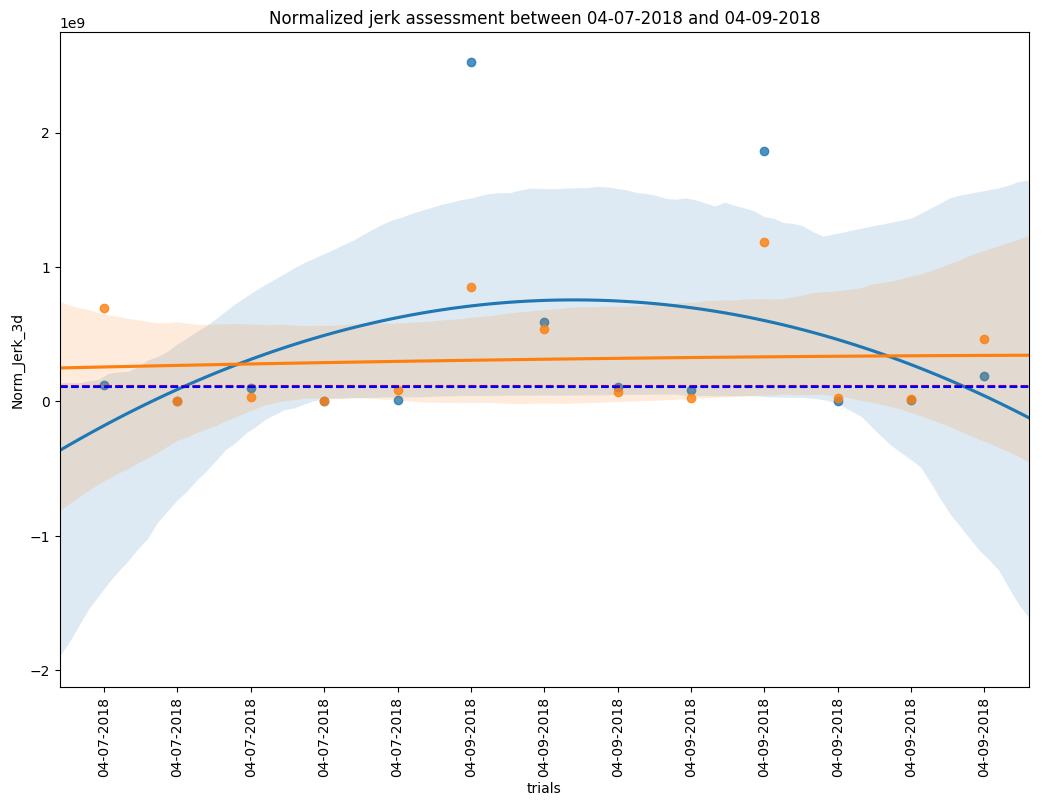

In [36]:
period_title = metric + ' assessment between ' + start_date + ' and ' + end_date
period_display_df = overtime_analysis(period_df, metric_left, metric_right, period_title, baseline_dataframe=health_df)

## Trend by game type

In [37]:
# list all the game types
print(stroke_df._Type.unique())

['standing' 'SitWeights' 'stand weights' 'stand step' 'sitsixtargets']


In [38]:
selected_type = 'SitWeights'
one_game_df = stroke_df.loc[stroke_df['_Type'] == selected_type]
one_game_df = one_game_df[[metric_left,metric_right,'_Date','_Type','_Time']]
display(one_game_df[:5])

,Norm_Jerk_3d_Left,Norm_Jerk_3d_Right,_Date,_Type,_Time
3,3.210509e+08,2.436368e+08,04-12-2018,SitWeights,07-58-PM
4,5.722753e+07,1.766465e+08,04-12-2018,SitWeights,08-01-PM
9,1.129216e+09,3.176664e+08,04-14-2018,SitWeights,10-06-AM
10,5.851705e+07,5.223452e+07,04-14-2018,SitWeights,10-09-AM
25,3.411321e+09,2.047161e+09,04-23-2018,SitWeights,08-47-PM


left baseline = 116099562.982066, right baseline = 105513241.429094.


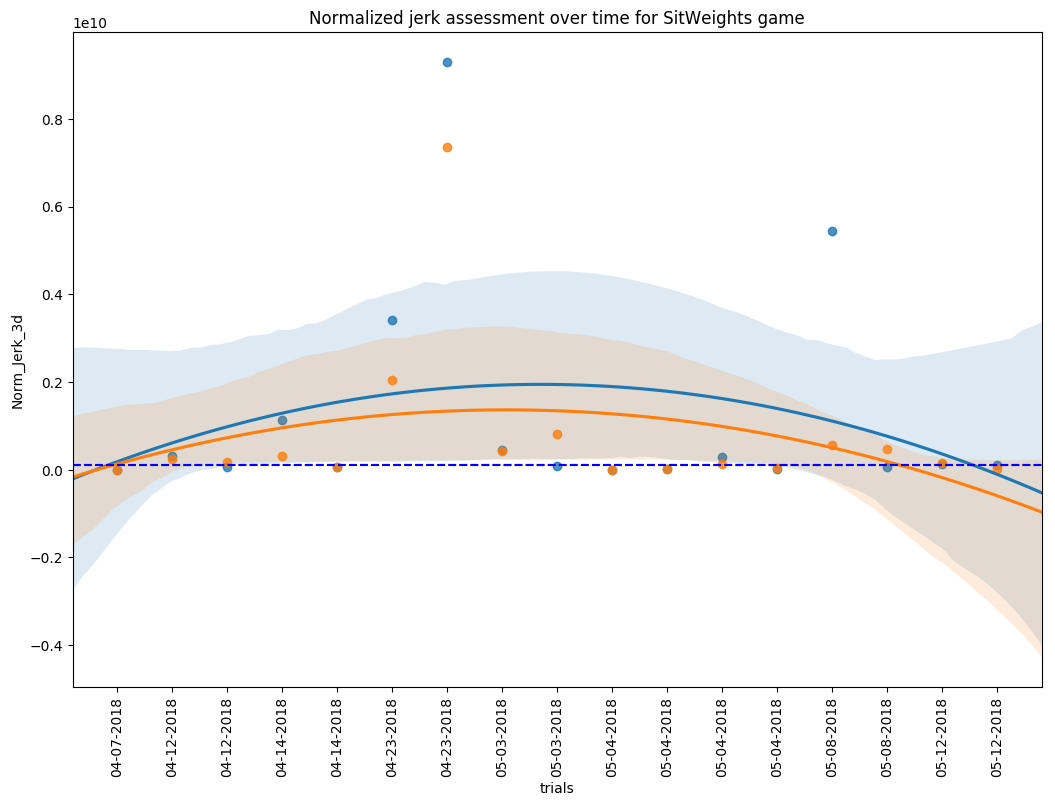

In [39]:
one_game_title = metric + ' assessment over time for ' + selected_type + ' game'
one_game_display_df = overtime_analysis(one_game_df, metric_left, metric_right, one_game_title , baseline_dataframe=health_df)